# Simulation

* This notebook contains the codes to conduct simulation in Section 6.
  - Codes for Section 6.4 are in another notebook. See [the notebook for miners' profit](https://github.com/okuchap/BDA/blob/master/notebook/miner_profit.ipynb)
* You can view and download this notebook at my [github repo](https://github.com/okuchap/DAA_Lucas). (https://github.com/okuchap/DAA_Lucas)

In [1]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import time
from datetime import datetime
import scipy.optimize as opt
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
plt.style.use("ggplot")
mpl.pyplot.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams["font.size"] = 13
#mpl.rcParams["font.family"] = 'Osaka'

import sys
sys.path.append('../code/')

from simulation_fixed_path import *
from hash import *
from plot_path import *

## Specification of Hash function

* We need to tune the shape of the hash supply function $\Phi$.


* Use BTC data from October 2018 to December 2018 to obtain MLS.
    - See also [the notebook for empirical analysis](https://github.com/okuchap/BDA/blob/master/notebook/empirical_analysis.ipynb)
    - We have estimated the shape of the hash supply function:
$$
\hat{\Phi}(R) := 23.59 + 9.02 R
$$
    - Note that the range of expected return in the target period is $[1.58, 3.12]$.


* The upper bound of the hash supply is set to be 55 EHash.


* Other properties that the hash supply function is expected to satisfy:
    - the supply should be almost 0 in case $R < 0.8$.
    - the supply increases rapidly on the interval $[1, 2]$.
    - ubd=55, center=1.5, slope=3 seems to work well.
    
* We have decided to use the following hash supply function that sarisfies the conditions above in our simulation:
\[
\Phi(R) := \frac{55}{1 + \mathrm{e}^{-3(R - 1.5)}}
\]


* See the graph below for its shape:

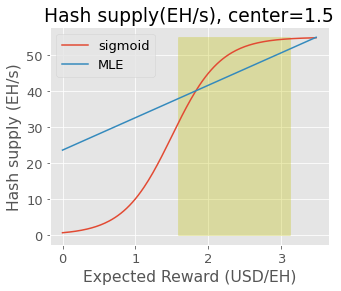

In [2]:
plot_hash(center=1.5, slope=3, ubd=55)

## Simulation

**Notation**

* discrete time $t \in \mathbb{N}$
* $B(t)$: blocktime, or time needed for generate $t$-th block (min)
* $S(t)$: price in period $t$ (USD)
* $H(t)$: hash rate in period $t$ (EH/s)
* $W(t)$: "winning rate" = "the probability that one exahash calculation finds out the nonce" in period $t$
* $M(t)$: the block reward in period $t$ (measured by the cryptocurrency)

* The timing in period $t$:
    - First, $W(t), S(t)$ is determined;
    - Then, $H(t)$ is determined;
    - Lastly, $B(t)$ realizes.

**Ecosystem**

1. Price motion
$$
S(t+1) - S(t) = \mu S(t)B(t) + \sigma S(t)\sqrt{B(t)} \epsilon(t)
$$


2. Block generation
$$
B(t) \sim \mathrm{Exp}(W(t)H(t))
$$
where $\mathrm{Exp}(\lambda)$ denotes the exponential distribution with intensity $\lambda$.


3. Hash supply
$$
H(t) = h(W(t)M(t)S(t))
$$
where $M(t) \equiv 12.5$(USD) is a fixed block reward and $R(t) := W(t)M(t)S(t)$ is the expected return in period $t$(USD/EH).


4. Difficulty Adjustment (BTC)

$T := 2016$
$$
    W(t+1) = \begin{cases}
        W(t)\cdot\cfrac{\sum_{s = t - T + 1}^{t}B(s)}{T\cdot \bar{B}} & \text{ if }t \equiv 0 \;(\bmod\; T)\\
        W(t) & \text{ otherwise}
    \end{cases}
$$

* In the real-world, BTC deploys `sim_BTC_bounded`:

    - In case $t \equiv 0 \mod 2016$
$$
\frac{W(t+1)}{W(t)} := 
\min \left\{
\max \left\{
0.25,
\frac{\sum_{s = t - T + 1}^{t}B(s)}{T\cdot \bar{B}}
\right\}, 4
\right\}
\in [0.25, 4]
$$

* The update rule of BCH is

\[
W(t+1) = \frac{\sum_{s=t-T+1}^t B(s)}{B^*} \cdot \left( \sum_{s=t-T+1}^t \frac{1}{W(s)} \right)^{-1}
\]

* The update rule of DAA-2'(below, `pseudoBCH`) is
$$
    W(t+1) =
    \cfrac{\sum_{s=t-T+1}^t W(s)}{T}
    \cdot
    \cfrac{\sum_{s = t - T + 1}^{t}B(s)}{T\cdot \bar{B}}.
$$

### Volatility $\sigma$

* Historical volatility(/minute) in the target period is $\hat{\sigma} := 0.001117728$

### Implementation

* See `code/simulation_fixed_path.py` for details.

### Data

* The raw data is contained in `BTCdata_2.csv`

* As we did in [the notebook for empirical analysis](https://github.com/okuchap/BDA/blob/master/notebook/empirical_analysis.ipynb), we fixed the data on blocktime for the whole dataset. The data with adjusted blocktime is stored in `BTCdata_timeadjusted.csv`.

  - See the Appendix of this notebook to see how we make `BTCdata_timeadjusted.csv` and related datesets we use below.

* Pick some period from the real-world data used in the simulation.

In [6]:
path = '../data/BTCdata_presim.csv'
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={'blocktime': 'block_times', 'price': 'prices', 'probability of success /Eh': 'winning_rates'})
df.head()

,height,time,block_times,prices,winning_rates,expected return (USD/Eh)
0,549427,2018-11-09 19:26:14,5.783333,6343.32,0.000032,2.587754
1,549428,2018-11-09 19:26:20,0.100000,6343.32,0.000032,2.574300
2,549429,2018-11-09 19:37:51,11.516667,6341.26,0.000032,2.593078
3,549430,2018-11-09 19:45:57,8.100000,6341.26,0.000032,2.595087
4,549431,2018-11-09 19:54:51,8.900000,6341.26,0.000032,2.591786


In [5]:
df.shape

(2016, 6)

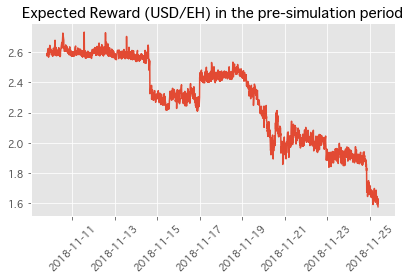

In [6]:
fig = plt.figure()
ax = plt.subplot()
x = df['time']
y = df['expected return (USD/Eh)']
ax.plot(x,y)
ax.set_title('Expected Reward (USD/EH) in the pre-simulation period')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### Generate simulation data

* First, try generating 1000 observations to see how our code works.

In [7]:
from simulation_fixed_path import *

path = '../data/BTCdata_presim.csv'
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={'blocktime': 'block_times', 'price': 'prices', 'probability of success /Eh': 'winning_rates'})
df.tail()

,height,time,block_times,prices,winning_rates,expected return (USD/Eh)
2011,551438,2018-11-25 08:35:20,6.250000,3604.59,0.000035,1.591790
2012,551439,2018-11-25 08:52:45,17.416667,3604.59,0.000035,1.610502
2013,551440,2018-11-25 09:21:09,28.400000,3604.59,0.000035,1.630853
2014,551441,2018-11-25 09:22:16,1.116667,3604.59,0.000035,1.585960
2015,551442,2018-11-25 09:22:42,0.433333,3604.59,0.000035,1.577661


In [7]:
# generate price data (1000 obs.)
# price shock = 0
init_price = df.loc[143, 'prices']
sim = simulation()
num_iter = 1000

df_price = pd.DataFrame()
for iter in range(num_iter):
    df_price['iter_{}'.format(iter)] = sim.generate_prices(init_price=init_price)
df_price.to_csv('/Volumes/Data/research/BDA/sim_prices_ps=0.csv', index=False)    

In [13]:
# generate r.v.'s following Exp(1) (1000 obs.)
# price shock = 0
sim = simulation()
num_iter = 1000

df_exprvs = pd.DataFrame()
for iter in range(num_iter):
    df_exprvs['iter_{}'.format(iter)] = sim.generate_exprvs()
df_exprvs.to_csv('/Volumes/Data/research/BDA/sim_exprvs.csv', index=False)    

In [4]:
df_exprvs = pd.read_csv('/Volumes/Data/research/BDA/simulation/sim_exprvs.csv')
df_price = pd.read_csv('/Volumes/Data/research/BDA/simulation/sim_prices_ps=0.csv')

The example below show how we can use the class for simulation defined in `simulation_fixed_path.py`.

In [4]:
sim = simulation(prev_data=df)

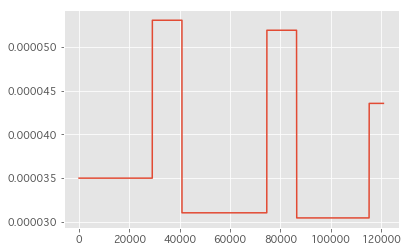

In [12]:
x = sim.block_times.cumsum()
y = sim.winning_rates
plt.plot(x,y)
plt.show()

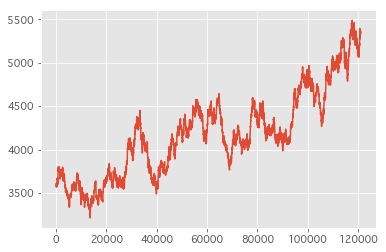

In [13]:
x = sim.block_times.cumsum()
y = sim.prices
plt.plot(x,y)
plt.show()

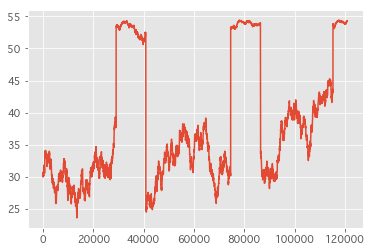

In [14]:
x = sim.block_times.cumsum()
y = sim.hash_rates
plt.plot(x,y)
plt.show()

#### Simulation with a small data set

* Next, generate a small data set to estimate how long the simulation will take if we increase the number of iterations.

In [7]:
# no price shock
## takes 74 minutes

num_iter = 1000
price_shock = 0

df_BTC = pd.DataFrame()
df_BCH = pd.DataFrame()
df_BTC_bdd = pd.DataFrame()
df_BCH_bdd = pd.DataFrame()
df_pseudoBCH = pd.DataFrame()
df_DAA_4 = pd.DataFrame()

for iter in range(num_iter):
    prices = df_price.loc[:, 'iter_{}'.format(iter)]
    exprvs = df_exprvs.loc[:, 'iter_{}'.format(iter)]
    _ = pd.DataFrame()
    _['iter_{}'.format(iter)] = sim.sim_BTC(prices=prices, exprvs=exprvs)
    df_BTC = pd.concat([df_BTC, _], axis=1)

    _ = pd.DataFrame()
    _['iter_{}'.format(iter)] = sim.sim_BCH(prices=prices, exprvs=exprvs)
    df_BCH = pd.concat([df_BCH, _], axis=1)

    _ = pd.DataFrame()
    _['iter_{}'.format(iter)] = sim.sim_BTC_bdd(prices=prices, exprvs=exprvs)
    df_BTC_bdd = pd.concat([df_BTC_bdd, _], axis=1)

    _ = pd.DataFrame()
    _['iter_{}'.format(iter)] = sim.sim_BCH_bdd(prices=prices, exprvs=exprvs)
    df_BCH_bdd = pd.concat([df_BCH_bdd, _], axis=1)

    _ = pd.DataFrame()
    _['iter_{}'.format(iter)] = sim.sim_pseudoBCH(prices=prices, exprvs=exprvs)
    df_pseudoBCH = pd.concat([df_pseudoBCH, _], axis=1)
    
    _ = pd.DataFrame()
    _['iter_{}'.format(iter)] = sim.sim_DAA_4(prices=prices, exprvs=exprvs)
    df_DAA_4 = pd.concat([df_DAA_4, _], axis=1)
    
df_BTC.to_csv('/Volumes/Data/research/BDA/simulation/BTC_blocktime_ps{}.csv'.format(price_shock))
df_BCH.to_csv('/Volumes/Data/research/BDA/simulation/BCH_blocktime_ps{}.csv'.format(price_shock))
df_BTC_bdd.to_csv('/Volumes/Data/research/BDA/simulation/BTC_bdd_blocktime_ps{}.csv'.format(price_shock))
df_BCH_bdd.to_csv('/Volumes/Data/research/BDA/simulation/BCH_bdd_blocktime_ps{}.csv'.format(price_shock))
df_pseudoBCH.to_csv('/Volumes/Data/research/BDA/simulation/pseudoBCH_blocktime_ps{}.csv'.format(price_shock))
df_DAA_4.to_csv('/Volumes/Data/research/BDA/simulation/DAA_4_blocktime_ps{}.csv'.format(price_shock))


In [8]:
df_BTC = pd.read_csv('/Volumes/Data/research/BDA/simulation/BTC_blocktime_ps0.csv', index_col=0)
df_BCH = pd.read_csv('/Volumes/Data/research/BDA/simulation/BCH_blocktime_ps0.csv', index_col=0)
df_BTC_bdd = pd.read_csv('/Volumes/Data/research/BDA/simulation/BTC_bdd_blocktime_ps0.csv', index_col=0)
df_BCH_bdd = pd.read_csv('/Volumes/Data/research/BDA/simulation/BCH_bdd_blocktime_ps0.csv', index_col=0)
df_pseudoBCH = pd.read_csv('/Volumes/Data/research/BDA/simulation/pseudoBCH_blocktime_ps0.csv', index_col=0)
df_DAA_4 = pd.read_csv('/Volumes/Data/research/BDA/simulation/DAA_4_blocktime_ps0.csv', index_col=0)

In [70]:
for df in [df_BTC, df_BTC_bdd, df_BCH, df_BCH_bdd, df_pseudoBCH, df_DAA_4]:
    mean, std, over60, over120, over180 = stats_fixed_path(df)
    print('mean: {:.3f}, std: {:.3f}, >60: {}, >120: {}, >180: {}'.format(mean, std, over60, over120, over180))

mean: 14.792, std: 21.472, >60: 1.0, >120: 0.911, >180: 0.644
mean: 14.784, std: 21.419, >60: 1.0, >120: 0.911, >180: 0.644
mean: 10.035, std: 10.223, >60: 1.0, >120: 0.194, >180: 0.001
mean: 10.035, std: 10.223, >60: 1.0, >120: 0.194, >180: 0.001
mean: 10.017, std: 10.203, >60: 1.0, >120: 0.185, >180: 0.0
mean: 10.092, std: 10.311, >60: 1.0, >120: 0.224, >180: 0.004


#### Visual comparison among different DAAs

In [4]:
# import data
path = '../data/BTCdata_presim.csv'
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={'blocktime': 'block_times', 'price': 'prices', 'probability of success /Eh': 'winning_rates'})
#df.tail()

df_exprvs = pd.read_csv('/Volumes/Data/research/BDA/simulation/sim_exprvs.csv')
df_price = pd.read_csv('/Volumes/Data/research/BDA/simulation/sim_prices_ps=0.csv')

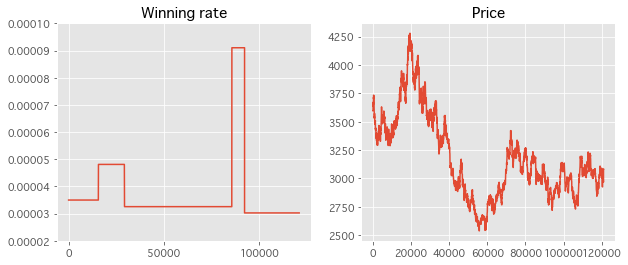

In [5]:
# 22, 482
# 3, 6
no_iter = 3

prices = df_price.loc[:, 'iter_{}'.format(no_iter)]
exprvs = df_exprvs.loc[:,'iter_{}'.format(no_iter)]

sim_BTC = simulation(prev_data=df)
sim_BTC.sim_BTC(prices=prices, exprvs=exprvs)

mpl.pyplot.rcParams['figure.figsize'] = (10.0, 4.0)
x = sim_BTC.block_times.cumsum()
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(x, sim_BTC.winning_rates)
ax1.set_title('Winning rate')
ax1.set_ylim(0.00002, 0.0001)
#ax1.tick_params(direction = "inout", length = 5)
ax1.set_xticks(np.array([0,50000,100000]))
ax2 = fig.add_subplot(1,2,2)
ax2.plot(x, sim_BTC.prices)
ax2.set_title('Price')
plt.show()

In [6]:
sim_BTC = simulation(prev_data=df)
sim_BTC.sim_BTC(prices=prices, exprvs=exprvs)
sim_BCH = simulation(prev_data=df)
sim_BCH.sim_BCH(prices=prices, exprvs=exprvs)

array([ 0.142,  9.027,  8.86 , ..., 24.216,  0.817, 30.432])

In [7]:
# the number of blocks created in the simulations
print(sim_BTC.block_times.shape[0], sim_BCH.block_times.shape[0])

7703 12048


* Below is Figure 6 in Section 6.2.

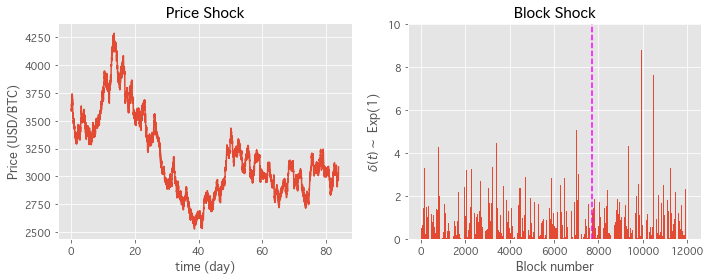

In [19]:
mpl.pyplot.rcParams['figure.figsize'] = (10.0, 4.0)

fig = plt.figure()
time = np.arange(12096)*10/1440
ax1 = fig.add_subplot(1,2,1)
ax1.plot(time, prices[:12096])
ax1.set_xlabel('time (day)')
ax1.set_ylabel('Price (USD/BTC)')
ax1.set_title('Price Shock')

ax2 = fig.add_subplot(1,2,2)
ax2.bar(np.arange(12048), exprvs[:12048])
ax2.set_xlabel('Block number')
ax2.set_ylabel('$\delta(t) \sim$ Exp(1)')
ax2.set_title('Block Shock')
ax2.axvline(x=7703, ls='--', color='magenta')
plt.tight_layout()
fig.align_labels()
plt.show()

In [7]:
sim_BTC = simulation(prev_data=df)
sim_BTC.sim_BTC(prices=prices, exprvs=exprvs)
sim_BCH = simulation(prev_data=df)
sim_BCH.sim_BCH(prices=prices, exprvs=exprvs)

array([ 0.142,  9.027,  8.86 , ..., 24.216,  0.817, 30.432])

Given a price $S(t)$, we can compare the realized path with the optimal path.

In order to obtain the optimal winning rate in period $t$, $W^*(t)$, we need to solve the following equasion with respect to $W^*(t)$.

\[
W^*(t) \cdot \Phi(W^*(t) \cdot M \cdot S(t)) = 1/(60  B^*)
\]
, where
\[
\Phi(R) = u \cdot \frac{1}{1 + \exp(-s(R - c))}
\]
Note that $B^*$ is multiplied by 60 in order for the unit of time to be second.


The above equasion is equivalent to:
\[
W^*(t) = \frac{-\frac{1}{s} \log(W^*(t) \cdot u \cdot (60  B^*) - 1) + c}{M \cdot S(t)} =: f(W^*(t))
\]

Though the equasion cannot be solved explicitly, it can be solved numerically since $f$ is a contraction mapping on some interval.

* Below is Figure 7 in Sectino 6.2.

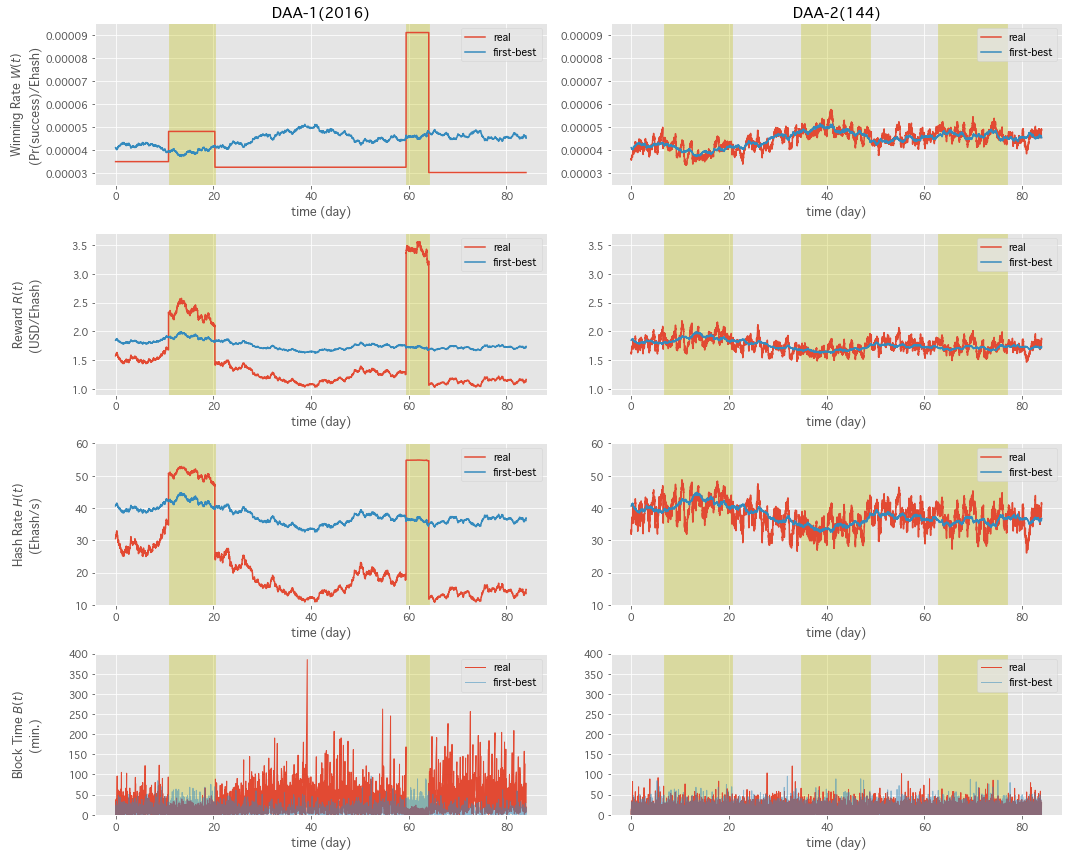

In [22]:
%autoreload
import warnings
warnings.filterwarnings('ignore')
mpl.pyplot.rcParams['figure.figsize'] = (15.0, 12.0)

sim_list = [sim_BTC, sim_BCH]
title_list = ['DAA-1(2016)', 'DAA-2(144)']
plot_paths_2(exprvs=exprvs, sim_list=sim_list, title_list=title_list)

In [15]:
# save the sample above as a csv
df_sample_BTC = pd.DataFrame()
df_sample_BTC['BTC_price'] = sim_BTC.prices
df_sample_BTC['BTC_winning_rate'] = sim_BTC.winning_rates
df_sample_BTC['BTC_blocktime'] = sim_BTC.block_times
df_sample_BTC['BTC_reward'] = sim_BTC.prices * sim_BTC.winning_rates * 12.5
df_sample_BTC['BTC_hash_rates'] = sim_BTC.hash_rates

df_sample_BCH = pd.DataFrame()
df_sample_BCH['BCH_price'] = sim_BCH.prices
df_sample_BCH['BCH_winning_rate'] = sim_BCH.winning_rates
df_sample_BCH['BCH_blocktime'] = sim_BCH.block_times
df_sample_BCH['BCH_reward'] = sim_BCH.prices * sim_BCH.winning_rates * 12.5
df_sample_BCH['BCH_hash_rates'] = sim_BCH.hash_rates

dir_sim='/Volumes/Data/research/BDA/simulation/'
df_sample_BTC.to_csv(dir_sim+'sample_path_BTC.csv', index=False)
df_sample_BCH.to_csv(dir_sim+'sample_path_BCH.csv', index=False)

### Experiment with a larger data set

* Additionally generate simulation data.
* We use the data with its sample size 5000.

In [5]:
generate_price_paths(price_shock=0, num_iter=5000, filename='_5000obs')
generate_exprvs(num_iter=5000, filename='_5000obs')
#generate_price_paths(price_shock=2000, num_iter=5000, filename='_5000obs')

In [43]:
path = '../data/BTCdata_presim.csv'
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={'blocktime': 'block_times', 'price': 'prices', 'probability of success /Eh': 'winning_rates'})
#df.head()

In [8]:
# takes 18 hours
generate_simulation_data(num_iter=5000, prev_data=df)

#### Statistics

In [19]:
dir_sim = '/Volumes/Data/research/BDA/simulation/'
filelist = [dir_sim+'BTC_blocktime_ps0_5000obs.csv',
            dir_sim+'BCH_blocktime_ps0_5000obs.csv',
            dir_sim+'BTC_bdd_blocktime_ps0_5000obs.csv',
            dir_sim+'BCH_bdd_blocktime_ps0_5000obs.csv',
            dir_sim+'pseudoBCH_blocktime_ps0_5000obs.csv',
            dir_sim+'DAA_4_blocktime_ps0_5000obs.csv',
            dir_sim+'BTC_blocktime_ps2000_5000obs.csv',
            dir_sim+'BCH_blocktime_ps2000_5000obs.csv',
            dir_sim+'BTC_bdd_blocktime_ps2000_5000obs.csv',
            dir_sim+'BCH_bdd_blocktime_ps2000_5000obs.csv',
            dir_sim+'pseudoBCH_blocktime_ps2000_5000obs.csv',
            dir_sim+'DAA_4_blocktime_ps2000_5000obs.csv'
            ]

In [35]:
%autoreload
df_stats = make_stats(filelist=filelist, dir_sim=dir_sim)

* The table below corresponds to Table 2 in Section 6.3.

In [36]:
df_stats

,BTC_blocktime_ps0_5000obs.csv,BCH_blocktime_ps0_5000obs.csv,BTC_bdd_blocktime_ps0_5000obs.csv,BCH_bdd_blocktime_ps0_5000obs.csv,pseudoBCH_blocktime_ps0_5000obs.csv,DAA_4_blocktime_ps0_5000obs.csv,BTC_blocktime_ps2000_5000obs.csv,BCH_blocktime_ps2000_5000obs.csv,BTC_bdd_blocktime_ps2000_5000obs.csv,BCH_bdd_blocktime_ps2000_5000obs.csv,pseudoBCH_blocktime_ps2000_5000obs.csv,DAA_4_blocktime_ps2000_5000obs.csv
mean,14.044305,11.242365,14.042658,11.242365,11.226132,11.290592,77.352414,11.287808,77.060483,11.287808,11.262357,11.313835
std,18.139603,10.920091,18.112977,10.920091,10.901839,11.001274,108.690643,11.340362,105.508436,11.340362,11.314051,11.219285
over60,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
over120,0.850430,0.183763,0.850430,0.183763,0.178964,0.212158,1.000000,0.945411,1.000000,0.945411,0.943411,0.735653
over180,0.533693,0.002400,0.533693,0.002400,0.002000,0.002200,1.000000,0.551890,1.000000,0.551890,0.549090,0.281144


In [38]:
df_stats.to_csv(dir_sim+'stats_5000obs.csv')

#### Compute optimal $w^*$

* (i) the grid size of the interval from which the initial value $w_0$ is chosen and (ii) the tolerance affects whether the contraction mapping successfully converges or not.

* For the moment, I choose `tol=1e-9` for (ii). (See the function `optimal_winning_rate` for details)

**Strategy**

* For $S \in [0, 10000]$, compute 'optimal_winning_rate'(S) and store the results $(W^*(S))_S$ as 'optimal_winning_rates.csv'.

* Compute $(W^*(S))_S$ with sufficiently fine grids; we can use it with interpolation.

In [40]:
prices_7000_11000 = np.arange(7000, 11001, 50)
res_7000_11000 = []
for price in prices_7000_11000:
    temp = optimal_winning_rate(price, W_init_low=1e-5, W_init_high=1e-4, W_grid=1e-11, tol=1e-9, num_iter=3000)
    res_7000_11000.append(temp)
res_7000_11000 = np.array(res_7000_11000)

../code/simulation_fixed_path.py:922: RuntimeWarning: invalid value encountered in log
  


In [45]:
_ = np.arange(100, 7000, 50)
_.shape

(138,)

In [46]:
res_ = np.hstack([res_under8000[:138], res_7000_11000])
res_.shape

(219,)

In [50]:
prices_6000_7000 = np.arange(6000, 7000, 50)
res_6000_7000 = []
for price in prices_6000_7000:
    temp = optimal_winning_rate(price, W_init_low=1e-5, W_init_high=1e-4, W_grid=1e-11, tol=1e-9, num_iter=3000)
    res_6000_7000.append(temp)
res_6000_7000 = np.array(res_6000_7000)

../code/simulation_fixed_path.py:922: RuntimeWarning: invalid value encountered in log
  


In [51]:
res_6000_11000 = np.hstack([res_6000_7000, res_7000_11000])
res_6000_11000.shape

(101,)

In [54]:
prices_6000 = np.arange(100, 6000, 50)
res_6000 = []
for price in prices_6000:
    temp = optimal_winning_rate(price, W_init_low=1e-5, W_init_high=1e-3, W_grid=1e-11, tol=1e-9, num_iter=3000)
    res_6000.append(temp)
res_6000 = np.array(res_6000)

In [63]:
df_w = pd.DataFrame()
df_w['opt_w'] =res
df_w.index = np.arange(100, 11001, 50)
df_w.head()

,opt_w
100,0.000480
150,0.000370
200,0.000306
250,0.000263
300,0.000232


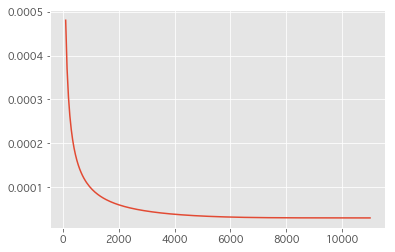

In [64]:
plt.plot(df_w)
plt.show()

In [69]:
df_w.loc[100, 'opt_w']

0.0004804473847941309

In [71]:
dir_sim='/Volumes/Data/research/BDA/simulation/'
df_w.to_csv(dir_sim+'opt_w.csv', index=True)

## Appendix: Data Cleaning

In [9]:
# This is the same function defined in the notebook for empirical analysis
def adjust_unixtime(raw_times):
    '''
    adjust block generation time.
    Conduct linear interpolation if the order of time stamps are reversed.
    
    Parameters
    ----------
    raw_times:
        pandas Series containing raw time stamps(unixtime)
        The index should starts at zero.
        
    Returns
    -------
    times:
        Adjusted time stamps.
    '''
    times = raw_times.copy()
    for i in range(times.shape[0] - 1):
        if times[i+1] - times[i] < 0:
            count = 1
            diff = -1
            while diff < 0:
                count += 1
                diff = times[i+count] - times[i]
            delta = times[i+count] - times[i]
            for j in range(count-1):
                times[i+j+1] = times[i] + (delta/count)*(j+1)

    return times

In [3]:
path = '../data/BTCdata_2.csv'
df_original = pd.read_csv(path, header=0)
#df_original.head()

In [13]:
columns = ['height', 'unixtime_precise', 'Close', 'probability of success /Eh', 'expected return (USD/Eh)']
df = df_original.loc[:, columns]
df['time'] = pd.to_datetime(df['unixtime_precise'].astype(int), unit='s')
name_dict = {'unixtime_precise':'unixtime', 'Close':'price'}
df = df.rename(columns=name_dict)
#df.head()

df['adjusted_unixtime'] = adjust_unixtime(df['unixtime'])
df['adjusted_blocktime'] = df['adjusted_unixtime'].diff()/60.0
df.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime
0,450001,1485382343,895.44,0.000593,6.935004,2017-01-25 22:12:23,1485382343,NaN
1,450002,1485383957,894.97,0.000593,7.424957,2017-01-25 22:39:17,1485383957,26.900000
2,450003,1485384299,894.97,0.000593,7.184180,2017-01-25 22:44:59,1485384299,5.700000
3,450004,1485384419,894.97,0.000593,7.025926,2017-01-25 22:46:59,1485384419,2.000000
4,450005,1485384847,894.97,0.000593,7.086069,2017-01-25 22:54:07,1485384847,7.133333


In [14]:
df.to_csv('../data/BTCdata_timeadjusted.csv', index=False)

In [15]:
df.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime
0,450001,1485382343,895.44,0.000593,6.935004,2017-01-25 22:12:23,1485382343,NaN
1,450002,1485383957,894.97,0.000593,7.424957,2017-01-25 22:39:17,1485383957,26.900000
2,450003,1485384299,894.97,0.000593,7.184180,2017-01-25 22:44:59,1485384299,5.700000
3,450004,1485384419,894.97,0.000593,7.025926,2017-01-25 22:46:59,1485384419,2.000000
4,450005,1485384847,894.97,0.000593,7.086069,2017-01-25 22:54:07,1485384847,7.133333


In [16]:
df['adjusted_time'] = pd.to_datetime(df['adjusted_unixtime'].astype(int), unit='s')
df.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,adjusted_time
0,450001,1485382343,895.44,0.000593,6.935004,2017-01-25 22:12:23,1485382343,NaN,2017-01-25 22:12:23
1,450002,1485383957,894.97,0.000593,7.424957,2017-01-25 22:39:17,1485383957,26.900000,2017-01-25 22:39:17
2,450003,1485384299,894.97,0.000593,7.184180,2017-01-25 22:44:59,1485384299,5.700000,2017-01-25 22:44:59
3,450004,1485384419,894.97,0.000593,7.025926,2017-01-25 22:46:59,1485384419,2.000000,2017-01-25 22:46:59
4,450005,1485384847,894.97,0.000593,7.086069,2017-01-25 22:54:07,1485384847,7.133333,2017-01-25 22:54:07


In [17]:
df_2018OctDec = df[(df['adjusted_time'] >= datetime(2018,10,1)) & (df['adjusted_time'] <= datetime(2019,1,1))]
df_2018OctDec = df_2018OctDec.reset_index(drop=True)

In [18]:
df_2018OctDec.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,adjusted_time
0,543835,1538352272,6621.3,0.000033,2.720620,2018-10-01 00:04:32,1538352272,18.633333,2018-10-01 00:04:32
1,543836,1538352799,6621.3,0.000033,2.711797,2018-10-01 00:13:19,1538352799,8.783333,2018-10-01 00:13:19
2,543837,1538352841,6621.3,0.000033,2.694189,2018-10-01 00:14:01,1538352841,0.700000,2018-10-01 00:14:01
3,543838,1538352940,6621.3,0.000033,2.697526,2018-10-01 00:15:40,1538352940,1.650000,2018-10-01 00:15:40
4,543839,1538353463,6621.3,0.000033,2.714195,2018-10-01 00:24:23,1538353463,8.716667,2018-10-01 00:24:23


In [19]:
df_2018OctDec.tail()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,adjusted_time
12619,556454,1546298203,3692.35,0.000041,1.918427,2018-12-31 23:16:43,1546298203,4.900000,2018-12-31 23:16:43
12620,556455,1546299695,3696.16,0.000041,1.934937,2018-12-31 23:41:35,1546299695,24.866667,2018-12-31 23:41:35
12621,556456,1546299762,3696.16,0.000041,1.917165,2018-12-31 23:42:42,1546299762,1.116667,2018-12-31 23:42:42
12622,556457,1546300239,3696.16,0.000041,1.920990,2018-12-31 23:50:39,1546300239,7.950000,2018-12-31 23:50:39
12623,556458,1546300592,3696.16,0.000041,1.918471,2018-12-31 23:56:32,1546300592,5.883333,2018-12-31 23:56:32


In [20]:
df_2018OctDec.to_csv('../data/BTCdata_2018OctDec.csv', index=False)

In [6]:
df_2018OctDec = pd.read_csv('../data/BTCdata_2018OctDec.csv')
df_2018OctDec.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,adjusted_time
0,543835,1538352272,6621.3,0.000033,2.720620,2018-10-01 00:04:32,1538352272,18.633333,2018-10-01 00:04:32
1,543836,1538352799,6621.3,0.000033,2.711797,2018-10-01 00:13:19,1538352799,8.783333,2018-10-01 00:13:19
2,543837,1538352841,6621.3,0.000033,2.694189,2018-10-01 00:14:01,1538352841,0.700000,2018-10-01 00:14:01
3,543838,1538352940,6621.3,0.000033,2.697526,2018-10-01 00:15:40,1538352940,1.650000,2018-10-01 00:15:40
4,543839,1538353463,6621.3,0.000033,2.714195,2018-10-01 00:24:23,1538353463,8.716667,2018-10-01 00:24:23


In [7]:
columns = ['height', 'adjusted_time', 'adjusted_blocktime', 'price', 'probability of success /Eh', 'expected return (USD/Eh)']
df_sim = df_2018OctDec.loc[:, columns]
name_dict = {'adjusted_time':'time', 'adjusted_blocktime':'blocktime'}
df_sim = df_sim.rename(columns=name_dict)
df_sim.head()

,height,time,blocktime,price,probability of success /Eh,expected return (USD/Eh)
0,543835,2018-10-01 00:04:32,18.633333,6621.3,0.000033,2.720620
1,543836,2018-10-01 00:13:19,8.783333,6621.3,0.000033,2.711797
2,543837,2018-10-01 00:14:01,0.700000,6621.3,0.000033,2.694189
3,543838,2018-10-01 00:15:40,1.650000,6621.3,0.000033,2.697526
4,543839,2018-10-01 00:24:23,8.716667,6621.3,0.000033,2.714195


In [31]:
df_sim.to_csv('../data/BTCdata_2018OctDec_sim.csv', index=False)

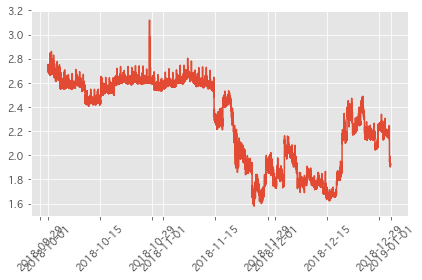

In [29]:
fig = plt.figure()
ax = plt.subplot()
x = df_sim['time']
y = df_sim['expected return (USD/Eh)']
ax.plot(x,y)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [16]:
df_sim['time'] = pd.to_datetime(df_sim['time'])
df_Nov = df_sim[(df_sim['time'] >= datetime(2018,11,1)) & (df_sim['time'] <= datetime(2018,12,1))]
df_Nov.head()

,height,time,blocktime,price,probability of success /Eh,expected return (USD/Eh)
4379,548214,2018-11-01 00:18:31,20.666667,6304.82,0.000032,2.578444
4380,548215,2018-11-01 00:22:32,4.016667,6304.82,0.000032,2.572693
4381,548216,2018-11-01 00:23:22,0.833333,6304.82,0.000032,2.557799
4382,548217,2018-11-01 00:24:57,1.583333,6304.82,0.000032,2.558311
4383,548218,2018-11-01 00:26:47,1.833333,6304.82,0.000032,2.559274


In [17]:
df_Nov.shape

(3870, 6)

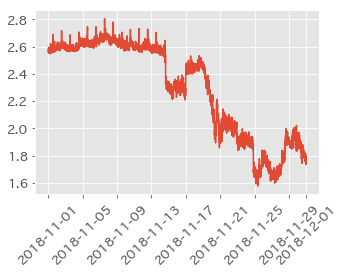

In [19]:
fig = plt.figure()
ax = plt.subplot()
x = df_Nov['time']
y = df_Nov['expected return (USD/Eh)']
ax.plot(x,y)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [20]:
df_Nov['expected return (USD/Eh)'].idxmin()

7607

In [21]:
df_Nov['expected return (USD/Eh)'][7607]

1.5776613819999998

In [22]:
df_Nov.loc[7607]

height                                     551442
time                          2018-11-25 09:22:42
blocktime                                0.433333
price                                     3604.59
probability of success /Eh            3.49948e-05
expected return (USD/Eh)                  1.57766
Name: 7607, dtype: object

* The lowest expected return is recorded at 2018-11-25 09:22:42(height 551442).

In [25]:
height_last = 551442
T = 2016
df_pre_simulation = df_Nov[(df_Nov['height'] >= height_last-T+1) & (df_Nov['height'] <= height_last)]

In [26]:
df_pre_simulation.head()

,height,time,blocktime,price,probability of success /Eh,expected return (USD/Eh)
5592,549427,2018-11-09 19:26:14,5.783333,6343.32,0.000032,2.587754
5593,549428,2018-11-09 19:26:20,0.100000,6343.32,0.000032,2.574300
5594,549429,2018-11-09 19:37:51,11.516667,6341.26,0.000032,2.593078
5595,549430,2018-11-09 19:45:57,8.100000,6341.26,0.000032,2.595087
5596,549431,2018-11-09 19:54:51,8.900000,6341.26,0.000032,2.591786


In [27]:
df_pre_simulation.tail()

,height,time,blocktime,price,probability of success /Eh,expected return (USD/Eh)
7603,551438,2018-11-25 08:35:20,6.250000,3604.59,0.000035,1.591790
7604,551439,2018-11-25 08:52:45,17.416667,3604.59,0.000035,1.610502
7605,551440,2018-11-25 09:21:09,28.400000,3604.59,0.000035,1.630853
7606,551441,2018-11-25 09:22:16,1.116667,3604.59,0.000035,1.585960
7607,551442,2018-11-25 09:22:42,0.433333,3604.59,0.000035,1.577661


In [28]:
df_pre_simulation.shape

(2016, 6)

In [29]:
df_pre_simulation.to_csv('../data/BTCdata_presim.csv', index=False)